In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# To make plots like drawing 
plt.xkcd()

In [4]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

### R Code 11.1

In [5]:
df = pd.read_csv('./data/chimpanzees.csv', sep=';')
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


- `pulled_left:` Outcome ${0, 1}$ - indicator if the animal pulled the left-hand lever.


- `prosoc_left:` Predict ${0, 1}$ - Indicator if left-hand lever was(1) or not(0) the prosocial options.


- `condition:` Predict ${0, 1}$ - Indicator if there is a partner (1) or not (0) in the end table. 

### R Code 11.2

In [6]:
df['treatment'] = 1 + df['prosoc_left'] + 2 * df['condition']
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,1,NaN,0,1,2,0,1,0,1
1,1,NaN,0,1,4,0,0,1,1
2,1,NaN,0,1,6,1,0,0,2
3,1,NaN,0,1,8,0,1,0,1
4,1,NaN,0,1,10,1,1,1,2


- treatment= $0$: prosoc_left = $0$ and contition= $0$: Two food items on **right** and **no partner**.


- treatment= $1$: prosoc_left = $1$ and contition= $0$: Two food items on **left** and **no partner**.


- treatment= $0$: prosoc_left = $0$ and contition= $1$: Two food items on **right** and **has partner**.


- treatment= $1$: prosoc_left = $1$ and contition= $1$: Two food items on **left** and **has partner**.

### R Code 11.3

In [7]:
df.pivot_table(['prosoc_left', 'condition'], 'treatment', aggfunc='count', margins=True)

,condition,prosoc_left
treatment,,
1,126,126
2,126,126
3,126,126
4,126,126
All,504,504


### R Code 11.4

In [8]:
def logit(p):
    return np.log(p) - np.log(1 - p)

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim \mbox{to be determined} $$
$$ \beta_k \sim \mbox{to be determined} $$

In [12]:
# quap code to get priori

### R Code 11.5

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha $$

$$ \alpha \sim Normal(0, \omega) $$


$\omega = 10$ to start

In [13]:
# extract prior from quap
omega = 10
N = 1000

norm_prior = np.random.normal(0, omega, N)

### R Code 11.6

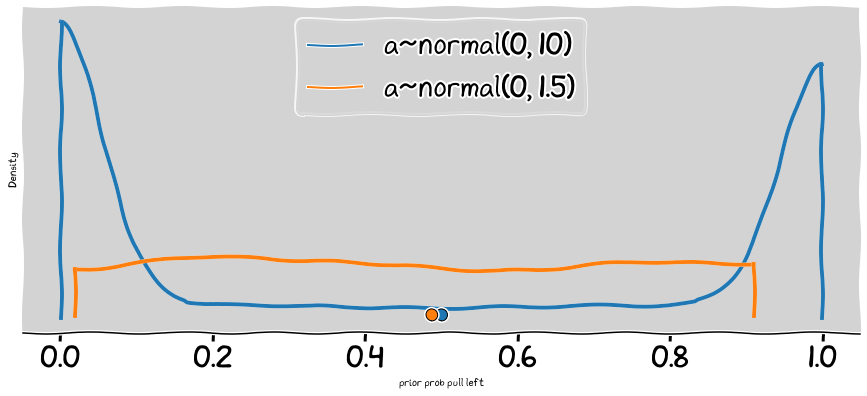

In [45]:
p = inv_logit(norm_prior)

omega = 1.5

better_p = inv_logit( np.random.normal(0, omega, N) ) 

az.plot_density([p, better_p],
                data_labels=['a~normal(0, 10)', 'a~normal(0, 1.5)'], 
                figsize=(15, 6))

plt.title('')
plt.xlabel('prior prob pull left')
plt.ylabel('Density')

plt.show()

### R Code 11.7

In [17]:
# quap model in R

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim Normal(0, 0.15) $$
$$ \beta_k \sim Normal(0, 10) $$

### R Code 11.8

In [60]:
p = []

alpha = np.random.normal(0, 1.5, N)
betas = np.random.normal(0, 10, (4, N))

p = [inv_logit(alpha + beta) for beta in betas]

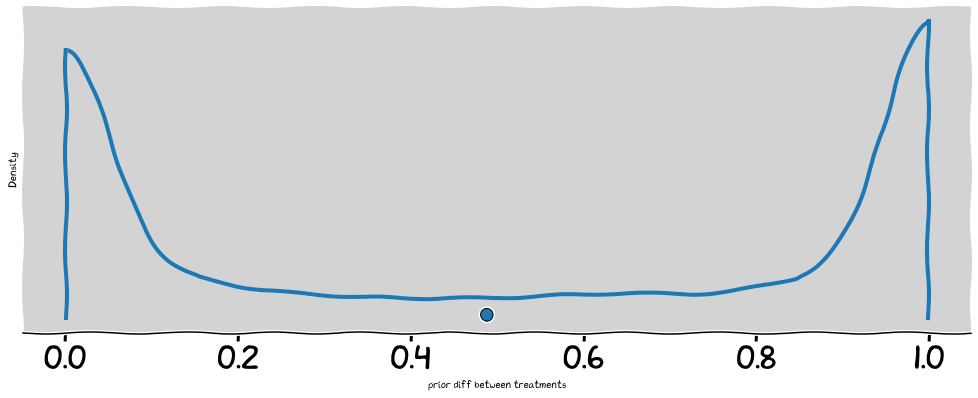

In [61]:
az.plot_density(np.absolute(p[0] - p[1]), figsize=(17, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

### R Code 11.9

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim Normal(0, 0.15) $$
$$ \beta_k \sim Normal(0, 0.5) $$

In [62]:
better_p = []

alpha = np.random.normal(0, 1.5, N)
betas = np.random.normal(0, 0.5, (4, N))

better_p = [inv_logit(alpha + beta) for beta in betas]

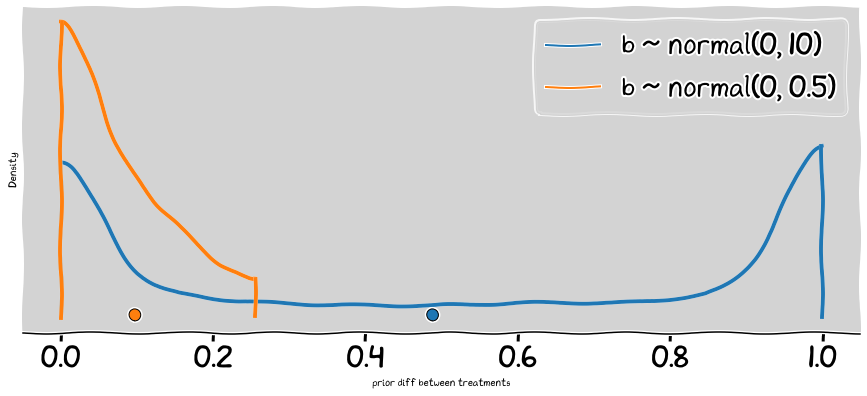

In [70]:
az.plot_density([
        np.absolute(p[0] - p[1]), 
        np.absolute(better_p[0] - better_p[1])
    ], 
    data_labels=['b ~ normal(0, 10)', 'b ~ normal(0, 0.5)'],
    figsize=(15, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

In [64]:
np.mean(np.absolute(better_p[0] - better_p[1]))

0.09695166507833222

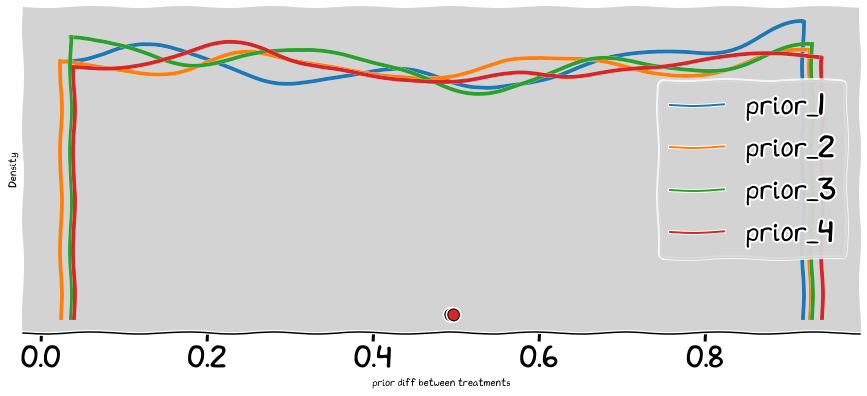

In [69]:
# Plot the 4 prior

az.plot_density([
        better_p[0], 
        better_p[1], 
        better_p[2], 
        better_p[3], 
    ],
    data_labels=['prior_1', 'prior_2', 'prior_3', 'prior_4'], 
    figsize=(15, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

### R Code 11.10

In [96]:
data_list = df[['pulled_left', 'actor', 'treatment']].to_dict('list')
data_list['N'] = len(df)
data_list['qty_chimpanzees'] = len(df.actor.unique())
data_list['qty_treatment'] = len(df.treatment.unique())

data_list.keys()

dict_keys(['pulled_left', 'actor', 'treatment', 'N', 'qty_chimpanzees', 'qty_treatment'])

### R Code 11.11

In [119]:
model = """
    data {
        int N;
        int qty_chimpanzees;
        int qty_treatment;
        int pulled_left[N];
        int actor[N];
        int treatment[N];
    }
    
    parameters {
        vector[qty_chimpanzees] alpha;
        vector[qty_treatment] beta;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 1.5);
        beta ~ normal(0, 0.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + beta[ treatment[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori = stan.build(model, data=data_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ddfihh48/model_ogtzmbou.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_ddfihh48/model_ogtzmbou.stan', line 7, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_ddfihh48/model_ogtzmbou.stan', line 8, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

In [120]:
samples_chimpanzees = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples,
    observed_data=['pulled_left', 'actor', 'treatment']
)

In [121]:
az.summary(samples_chimpanzees, var_names=['alpha', 'beta'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.450,0.329,-0.955,0.086,0.009,0.006,1385.0,2802.0,1.00
alpha[1],3.883,0.751,2.713,5.078,0.012,0.009,3838.0,2686.0,1.00
alpha[2],-0.744,0.335,-1.267,-0.184,0.009,0.006,1374.0,2076.0,1.00
alpha[3],-0.748,0.333,-1.292,-0.220,0.009,0.006,1464.0,2217.0,1.00
alpha[4],-0.448,0.323,-0.964,0.065,0.009,0.006,1335.0,2355.0,1.00
alpha[5],0.480,0.333,-0.036,0.999,0.009,0.006,1377.0,1925.0,1.00
alpha[6],1.956,0.415,1.245,2.569,0.009,0.007,1918.0,2603.0,1.00
beta[0],-0.042,0.285,-0.481,0.425,0.008,0.006,1200.0,2167.0,1.01
beta[1],0.478,0.282,0.024,0.917,0.008,0.006,1174.0,2314.0,1.00
beta[2],-0.383,0.285,-0.877,0.031,0.008,0.006,1235.0,2392.0,1.00


### R Code 11.12

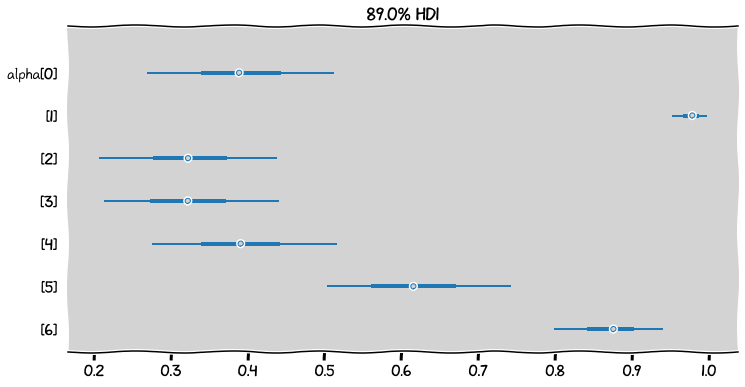

In [136]:
ax = az.plot_forest(samples_chimpanzees, 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['alpha'], 
                    transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(12, 6))

### R Code 11.13

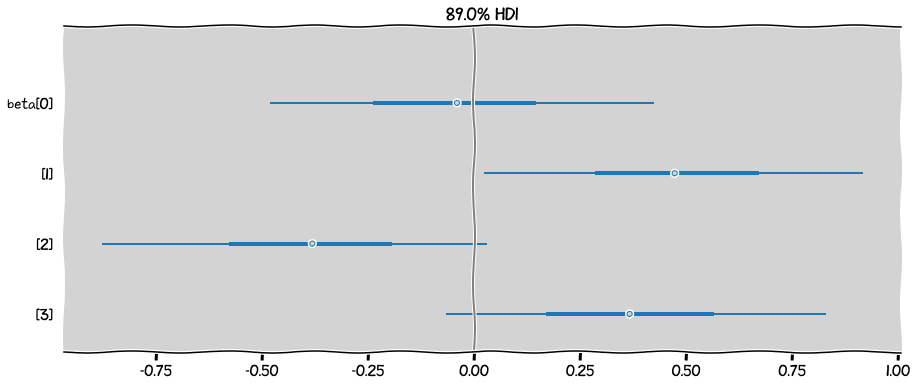

In [193]:
ax = az.plot_forest(samples_chimpanzees, 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['beta'], 
                    # transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(15, 6))
plt.axvline(x=0, c='gray')
plt.show()

### R Code 8.14

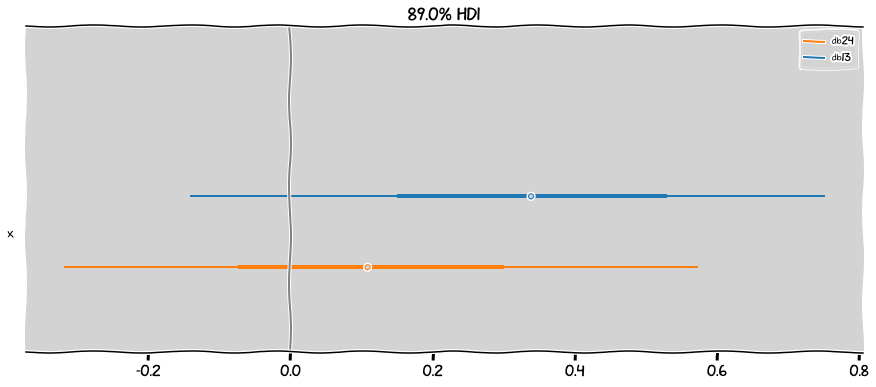

In [198]:
beta_0 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=0)
beta_1 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=1)
beta_2 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=2)
beta_3 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=3)

diff_beta_0_2 = az.extract(beta_0 - beta_2)
diff_beta_1_3 = az.extract(beta_1 - beta_3)

az.plot_forest(
    [diff_beta_0_2.beta.values, diff_beta_1_3.beta.values],
    combined=True,  # Joint all chains 
    kind="forestplot", # or ridgeplot to plot densities
    # transform=inv_logit,
    model_names=['db13', 'db24'],
    hdi_prob=0.89,
    figsize=(15, 6)
)

plt.axvline(x=0, c='gray')

plt.show()